# Exercício computacional 2: Projeto de filtros

Alunos: 
- Davi Giordano Valério, 11805273
- Henrique Lefundes da Silva, 11808280


In [1]:
using DSP, Plots, LaTeXStrings, LinearAlgebra, Plots.PlotMeasures

In [2]:
# Definindo configurações padrões para todos os gráficos
graph_settings = (top_margin = 5mm,
    bottom_margin = 5mm,
    left_margin = 5mm,
    right_margin = 5mm,
    size = (750, 500));

### 1.a) Projeto do filtro passa-baixas com mínimos quadrados
 Na figura abaixo, é possível visualizar o filtro passa-baixas com N=81 coeficientes implementado.

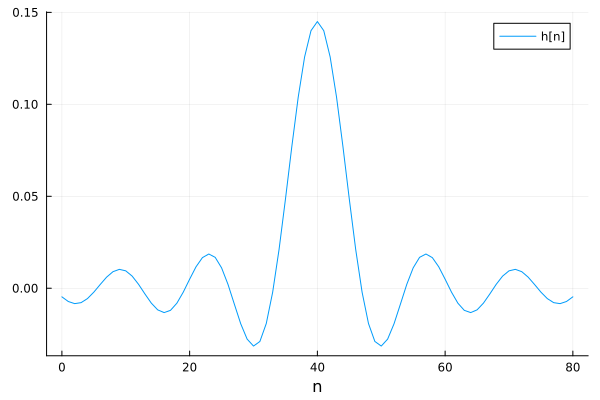

In [3]:
N = 81
n = 0:N-1
L = (N-1)/2
ωc = 29*π/200
hl = @. (ωc/π)*sinc((ωc/π)*(n-L))
plot(n, hl, label="h[n]")
xlabel!("n")

### 1.b) Projeto do filtro passa-altas com mínimos quadrados
 Na figura abaixo, é possível visualizar o filtro passa-altas com N=81 coeficientes implementado.

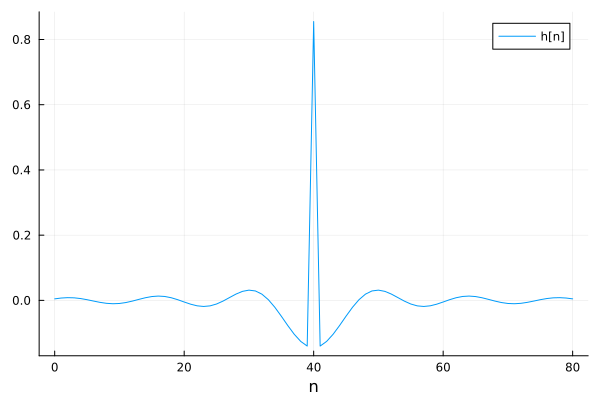

In [4]:
hh = @. sinc.(n.-L) - (ωc/π)*sinc((ωc/π)*(n-L)) # The sinc(n-L) works as an impulse 

plot(n, hh, label="h[n]")
xlabel!("n")

### 2. Implementação da convolução
Na célula abaixo, foi implementada a função 'conv( )' que recebe como entrada os coeficientes $h[n]$ com $n$ de $0$ a $N-1$ e $x[k]$, com $k$ de $0$ a $K-1$ e retorna a convolução entre $h[n]$ e $x[k]$, utilizando apenas laços for e comandos if-then-else. Além disso, o filtro assume que as entradas para $n<0$ são nulas e calcula a saída para os instantes de $0$ a $K-1$.

In [5]:
function conv(h::AbstractVector, x::AbstractVector)

    y = zeros(length(x))

    for n in 1:length(y)
        for k in 1:length(h)
            if (n - k + 1) > 0 && (n - k + 1) <= length(x)
                y[n] = y[n] + h[k]*x[n - k + 1]
            end
        end
    end

    return y
end

conv (generic function with 1 method)

### 3.a) Comparação entre a convolução implementada e 'filt' do DSP
Abaixo, é possível comparar a saída da convolução implementada anteriormente com a função filt para obter a saída dos filtros construídos para o sinal $$x[n] = cos(\pi n /25) + cos(\pi n /4)$$

In [78]:
n = 0:200-1

x = @. cos(π*n/25) + cos(π*n/4)
x1 = @. cos(π*n/25)
x2 = @. cos(π*n/4);

Em primeiro lugar, observa-se a resposta quando o passa baixa é aplicado:

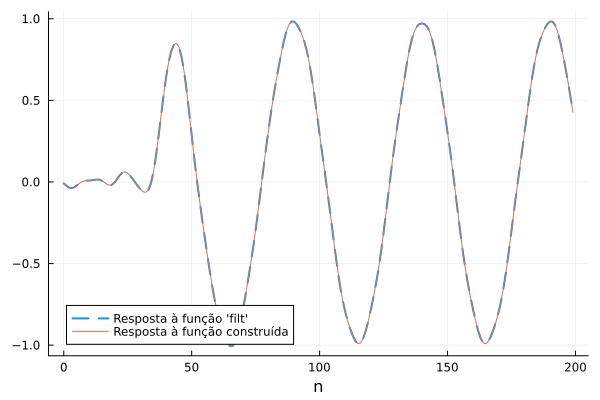

In [79]:
xfiltlow = filt(hl, x)
xconvlow = conv(hl, x)

x1 = @. cos(π*n/25)

plot(n, xfiltlow,  label = "Resposta à função 'filt'", linestyle=:dash, linewidth=2)
plot!(n, xconvlow, label = "Resposta à função construída")
xlabel!("n")

Em seguida, a resposta do passa-altas:

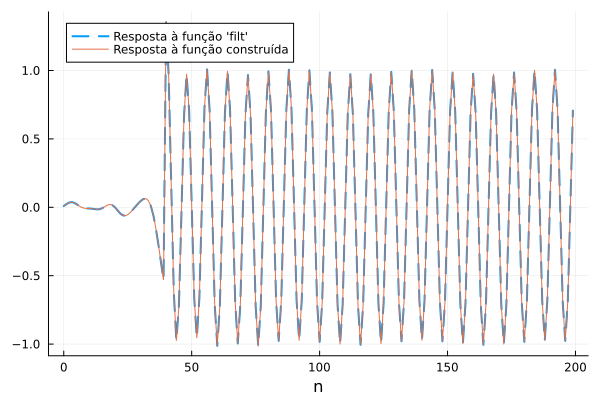

In [80]:
xfilthigh = filt(hh, x)
xconvhigh = conv(hh, x)

plot(n, xfilthigh,  label = "Resposta à função 'filt'", linestyle=:dash, linewidth=2)
plot!(n, xconvhigh, label = "Resposta à função construída")
xlabel!("n")

Em ambos os casos, é possível observar um período de transitório, seguido do cosseno cuja frequência não foi filtrada. Além disso, as respostas para ambos os métodos foi idêntica para o intervalo considerado, o que aponta que a função construída possui o comportamento esperado.

### 3.b) Resposta em frequência do filtro e análise da amplitude observada na saída

Nos gráficos a seguir, pode-se observar a resposta em frequência (módulo e fase) do filtro.

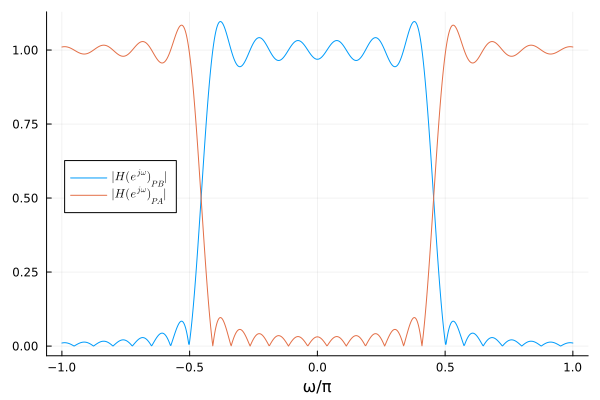

In [81]:
Hl = PolynomialRatio(hl, [1])
Hh = PolynomialRatio(hh, [1])
ω = range(-π, π, 1000)
HfreqLow = freqz(Hl, ω/π)
HfreqHigh = freqz(Hh, ω/π)

plot(ω/π, abs.(HfreqLow),  label = L"|H(e^{j\omega})_{PB}|", legend=:left)
plot!(ω/π, abs.(HfreqHigh), label = L"|H(e^{j\omega})_{PA}|")
xlabel!("ω/π")

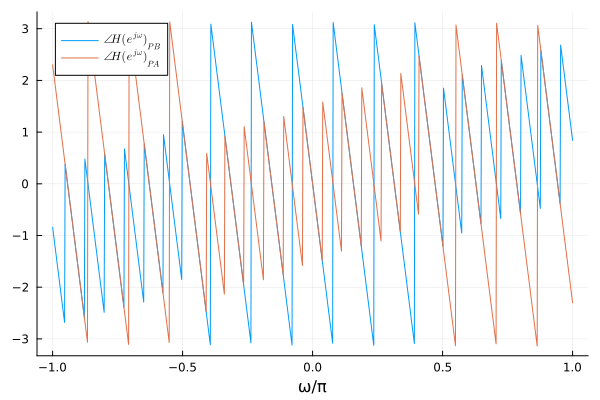

In [82]:
plot(ω/π, angle.(HfreqLow),  label = L"\angle H(e^{j\omega})_{PB}")
plot!(ω/π, angle.(HfreqHigh), label = L"\angle H(e^{j\omega})_{PA}")
xlabel!("ω/π")

A seguir, é feita uma análise comparativa entre a amplitude esperada no sinal de saída dos filtros e a amplitude obtida.

Na próxima figura é possível observar o cosseno com a menor frequência e o a resposta obtida para o passa baixas. Esperava-se que a amplitude da resposta fosse próxima de $1$, com alguma variação devido às oscilações da resposta em frequência do filtro para $\omega$ próximo de $0$.
 
Como a máscara de projeto do filtro não foi fornecida, não é possível dizer se a variação obtida está dentro do esperado. Apesar disso, supõe-se que a resposta não é satisfatória, visto que obteve-se uma variação da amplitude próxima a 20%.

# Na verdade vejo agora que isso é do transitório! Aumentar tamanho

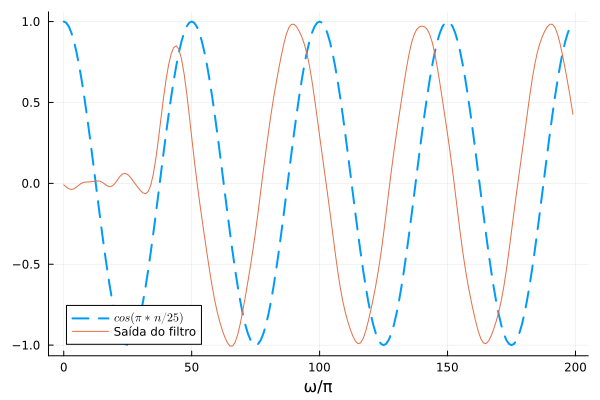

In [83]:
plot(n, x1,  linestyle=:dash, linewidth=2, label=L"cos(π*n/25)")
plot!(n, xfiltlow, label="Saída do filtro")
xlabel!("ω/π")

Para o passa alta, a resposta foi mais próxima do esperado, com uma variação menor da amplitude, como é possível observar na figura a seguir, em que podem ser vistos o cosseno com a maior amplitude e a saída do filtro passa-altas.

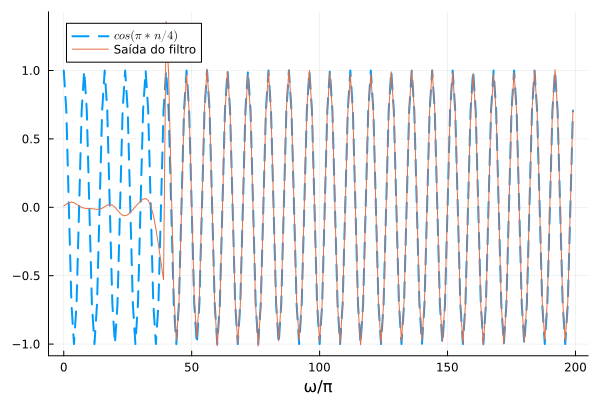

In [84]:
plot(n, x2,  linestyle=:dash, linewidth=2, label=L"cos(π*n/4)")
plot!(n, xfilthigh, label="Saída do filtro")
xlabel!("ω/π")

### 4. Filtro de Kaiser
Nesse item, serão implementados filtros com janela de Kaiser. As especificações fornecidas para máscara de projeto fornecidas são:
- Erro na banda passante menor ou igual a $0,005$
- Atenuação na banda de rejeição de pelo menos 0,001


Em primeiro lugar, definiu-se uma função para obter o $\beta$ da janela de Kaiser:

In [85]:
function βkaiser(A)
    return A < 21 ? 0 : A ≤ 50 ? 0.5842(A-21)^0.4 + 0.07886(A-21) : 0.1102(A - 8.7)
end 

βkaiser (generic function with 1 method)

Com a menor atenuação especificada, $\beta$ obtido foi de:

In [86]:
δp = 0.005
δr = 0.001

A = -20*log10(min(δp, δr))
β = βkaiser(A)
println("β = $β")

β = 5.65326


### Passa-baixas com janela de Kaiser:
No passa-baixas, deseja-se eliminar a frequênca $\pi/4$. Dessa forma, define-se $ω_p = π/25$ e $ω_r = π/4$. A frequência de corte escolhida será a média dessas frequências. Em seguida, obtém-se o número de coeficientes conforme a especificação da janela e por conseguinte o valor L. Por fim, o filtro é construído por meio da função 'kaiser( )'.

In [87]:
ωp = π/25
ωr = π/4
ωc = (ωp + ωr)/2

Nk = (A-8)/(2.285*(abs(ωr-ωp))) + 1
Nk = Int16(ceil(N))
Lk = (Nk-1)/2
println("Número de coeficientes: $Nk")

n = 0:Nk-1
hlkaiser = hl.*kaiser(Nk, β/π);

Número de coeficientes: 81


No próximo gráfico, é possível visualizar os coeficientes do filtro passa-baixas com a janela de Kaiser implementado.

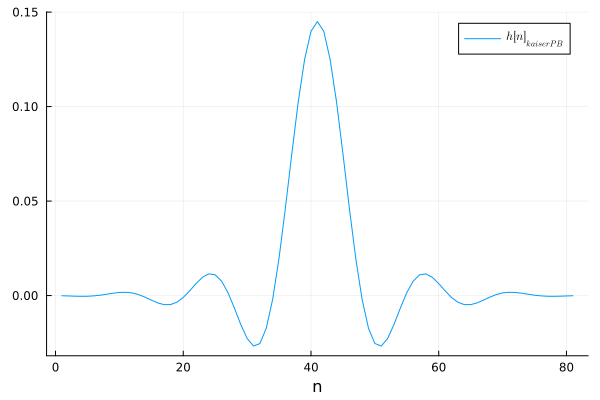

In [88]:
plot(hlkaiser, label = L"h[n]_{kaiserPB}")
xlabel!("n")

Em seguida, os gráficos do módulo e da fase da resposta em frequência do filtro passa baixa com janela de kaiser.

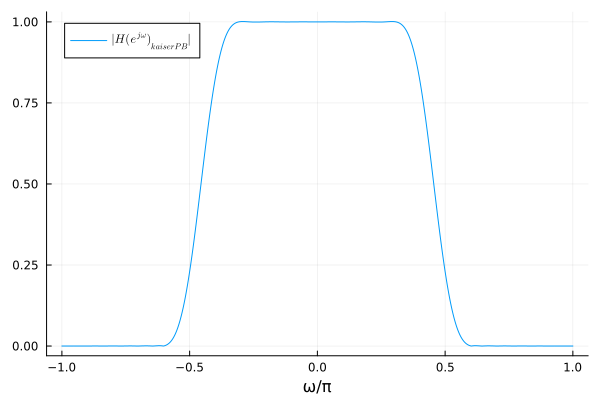

In [89]:
Hlkaiser = PolynomialRatio(hlkaiser, [1])
ω = range(-π, π, 1000)
Hlkaiser = freqz(Hlkaiser, ω/π)
plot(ω/π, abs.(Hlkaiser), label=L"|H(e^{j\omega})_{kaiserPB}|", legend=:topleft)
xlabel!("ω/π")

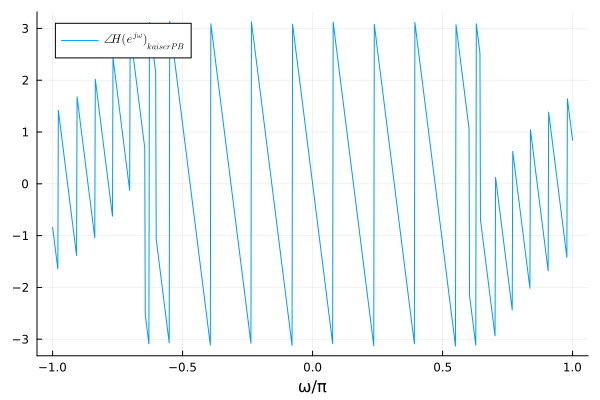

In [90]:
plot(ω/π, angle.(Hlkaiser), label = L"\angle H(e^{j\omega})_{kaiserPB}", legend=:topleft)
xlabel!("ω/π")

E, por fim, o sinal de saída após a convolução entre $x[n] = cos(\pi n /25) + cos(\pi n /4)$ e o filtro passa-baixas projetado, em comparação com o cosseno de menor frequência:

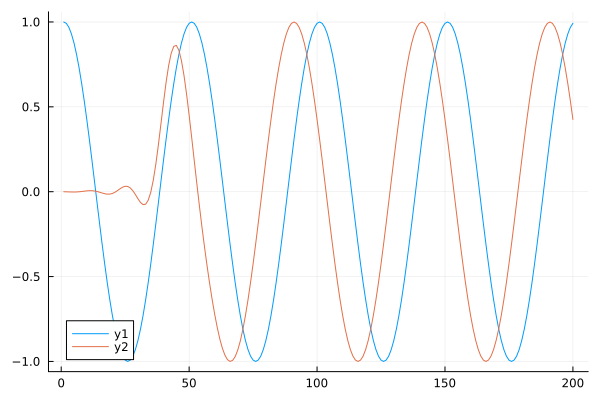

In [102]:
xkaiserlow = conv(hlkaiser, x)
# plot(n, x1,  linestyle=:dash, linewidth=2, label=L"cos(π*n/25)")
# plot!(n, xkaiserlow,  label = "Saída do filtro PB com Kaiser", legend=:topleft)
plot([x1 xkaiserlow])

Ao comparar a saída do filtro e a saída esperada, é possível dizer que o resultado do filtro é satisfatório.

# Comparar com o sinal e a saída desejados

## Passa-alta

In [96]:
ωp = π/4
ωr = π/25
ωc = (ωp + ωr)/2

Nk = (A-8)/(2.285*(abs(ωr-ωp))) + 1
Nk = Int16(ceil(N))
Lk = (Nk-1)/2

n = 0:Nk-1
hhkaiser = hh.*kaiser(Nk, β/π);

### Resposta no tempo

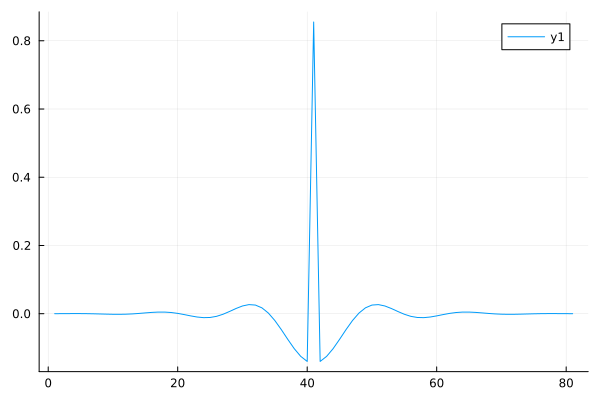

In [97]:
plot(hhkaiser)

### Resposta na frequência

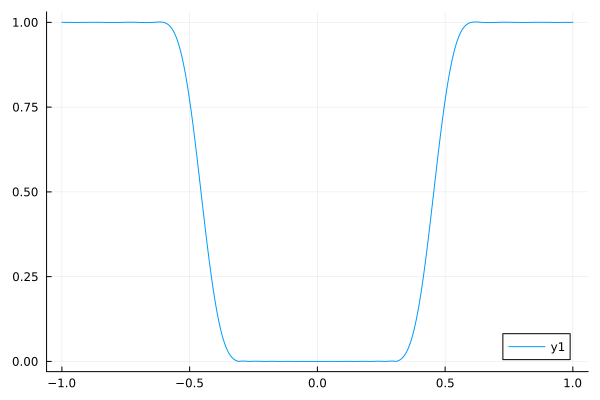

In [98]:
Hhkaiser = PolynomialRatio(hhkaiser, [1])
ω = range(-π, π, 1000)
Hhkaiser = freqz(Hhkaiser, ω/π)
plot(ω/π, abs.(Hhkaiser))

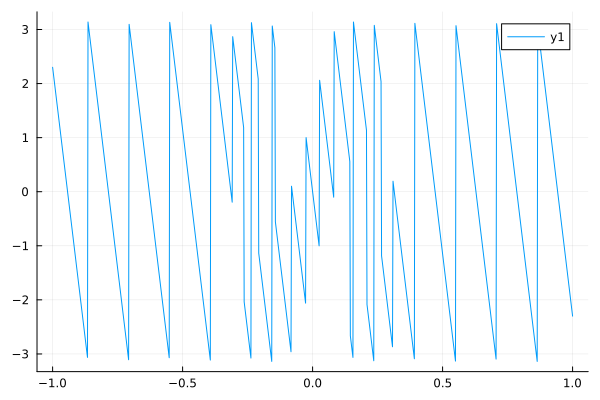

In [99]:
plot(ω/π, angle.(Hhkaiser))

### Sinal de saída

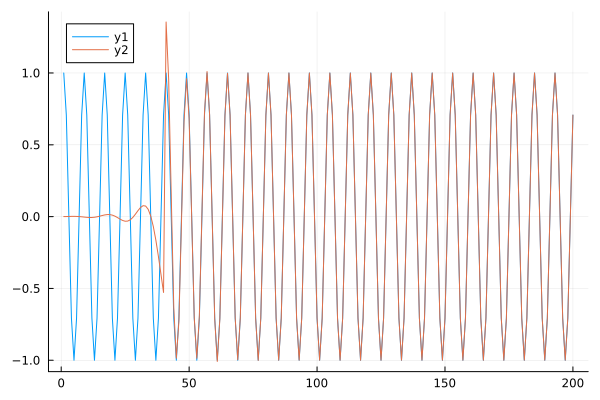

In [100]:
xkaiserhigh = conv(hhkaiser, x)

plot([x2 xkaiserhigh])

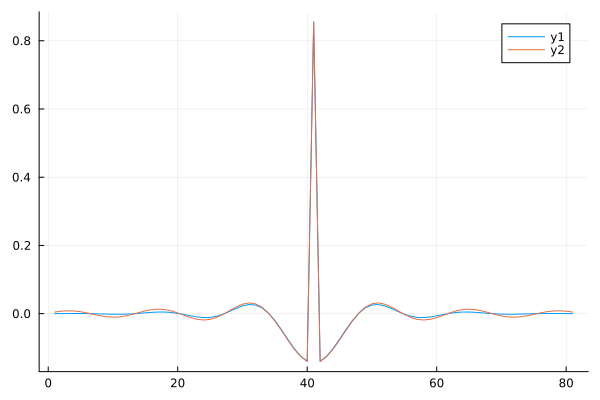

In [49]:
plot([hhkaiser hh])

# Item 5 [min-max (Parks-McClellan)]

## Passa-baixa

In [50]:
δp = 0.005
δr = 0.001

ωp = π/25
ωr = π/4

Nmm = ceil(Int,(-10*log10(δp*δr)-13)/(2.324*(abs(ωr-ωp)))) + 3

println(Nmm)

hlminmax = remez(Nmm, [(0, ωp/π) => (1, 1), (ωr/π, 1) => (0, δp/δr)]; Hz = 2)

30


30-element Vector{Float64}:
 -0.0009412258124797421
 -0.002402474508898725
 -0.004735534358544534
 -0.007544544610729283
 -0.009976284820815197
 -0.010681395411053868
 -0.008018620554494496
 -0.0004422738517846853
  0.013009611299134473
  0.032262028113742354
  ⋮
  0.013009611299134473
 -0.0004422738517846853
 -0.008018620554494496
 -0.010681395411053868
 -0.009976284820815197
 -0.007544544610729283
 -0.004735534358544534
 -0.002402474508898725
 -0.0009412258124797421

### Resposta no tempo

In [51]:
plot(hminmax)

UndefVarError: UndefVarError: `hminmax` not defined

### Resposta na frequência

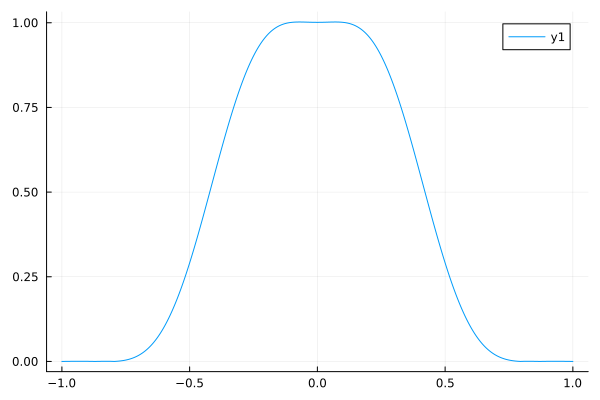

In [52]:
Hlminmax = PolynomialRatio(hlminmax, [1])
ω = range(-π, π, 1000)
Hlminmax = freqz(Hlminmax, ω/π)
plot(ω/π, abs.(Hlminmax))

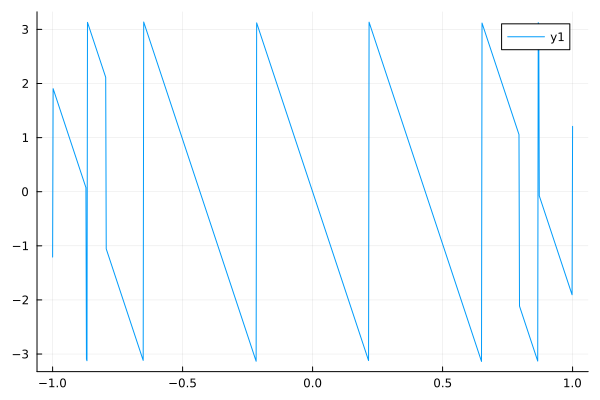

In [53]:
plot(ω/π, angle.(Hlminmax))

### Sinal de Saída

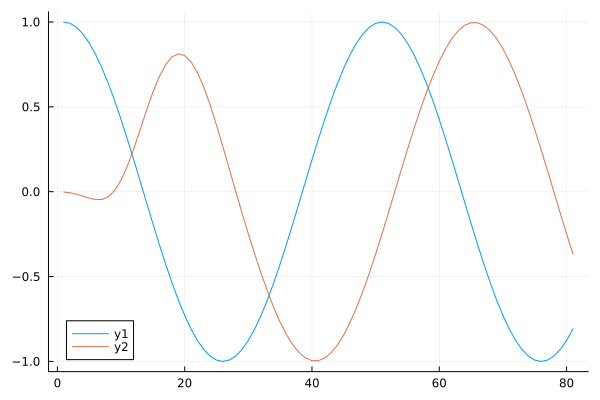

In [54]:
xminmaxlow = conv(hlminmax, x) 

plot([x1 xminmaxlow])

## Passa-alta

In [55]:
δp = 0.005
δr = 0.001

ωp = π/4
ωr = π/25

Nmm = ceil(Int,(-10*log10(δp*δr)-13)/(2.324*(abs(ωr-ωp)))) + 3

println(Nmm)

hhminmax = remez(Nmm, [(0, ωr/π) => (0, δp/δr), (ωp/π, 1) => (1, 1)]; Hz = 2)

30


30-element Vector{Float64}:
  0.7088665524558869
  0.7296085926432953
  0.9030878444165718
  0.6968396813723373
  0.28575277866426196
 -0.5423676013764538
 -1.3533048035645325
 -2.201576748715507
 -2.4889072230014966
 -2.4049339956652087
  ⋮
 -2.4889072230014966
 -2.201576748715507
 -1.3533048035645325
 -0.5423676013764538
  0.28575277866426196
  0.6968396813723373
  0.9030878444165718
  0.7296085926432953
  0.7088665524558869

### Resposta no tempo

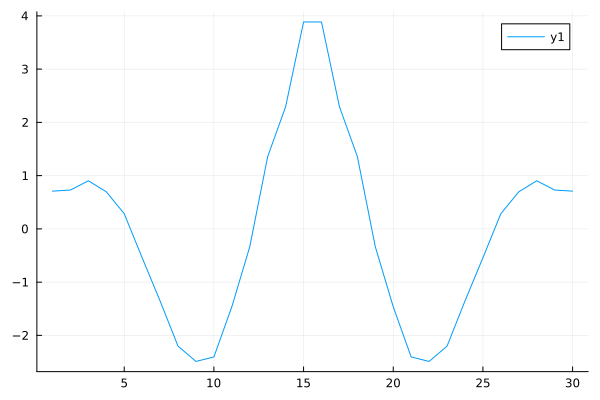

In [56]:
plot(hhminmax)

### Resposta na frequência

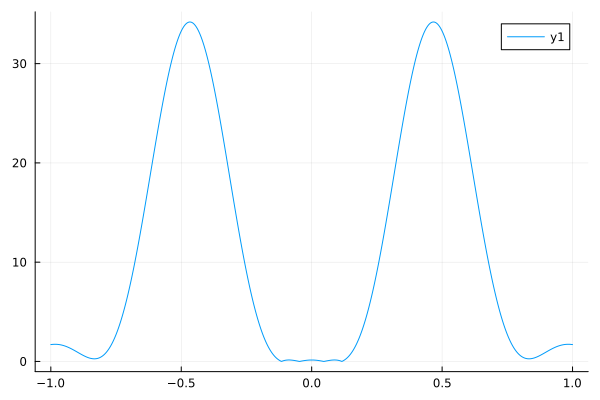

In [57]:
Hhminmax = PolynomialRatio(hhminmax, [1])
ω = range(-π, π, 1000)
Hhminmax = freqz(Hhminmax, ω/π)
plot(ω/π, abs.(Hhminmax))